### Notice: 
This is the notebook to share my data processing process with team containes partial imtermeidate results. Data is not open to public and cannot be shared.  

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
#from IPython.display import HTML
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

import statsmodels.api as sm
%matplotlib inline

# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
%load_ext autoreload
%autoreload 2

***
### Data Inital Processing

In [2]:
ads = pd.read_csv('merged.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Convert Date format:

In [4]:
def convert_date(df):
    '''
    input: df -- dataframe
    output: datetime format column named 'Days_'
    '''
    df['Days_'] = df['Days'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
    return df['Days_']

In [ ]:
ads['Days'] = convert_date(ads)

Convert dtypes into numeric (for some):

In [134]:
ads.dtypes

Ad Types                         object
Ad locations                     object
Ad sources                       object
Advertiser verticals             object
Creative sizes                   object
Ad requests                       int64
Matched requests                  int64
CPC ($)                         float64
Estimated revenue ($)           float64
Ad impressions                    int64
Ad eCPM ($)                     float64
Days_                    datetime64[ns]
AdU_mtch/no                      object
AdU_chanell                      object
AdU_language                     object
AdU_seg                          object
AdU_where                        object
dtype: object

In [53]:
def convet_str2int(df,v):
    '''
    input: 
        df -- dataframe 
        v -- 'variable names'
    output: a numerical column, replace the original 
    '''
    return df[v].apply(lambda x: int(str(x).replace(',','')))     

In [54]:
ads['Matched requests'] = convet_str2int(ads,'Matched requests')
ads['Ad requests'] = convet_str2int(ads,'Ad requests')
ads['Ad impressions'] = convet_str2int(ads,'Ad impressions')

Deal with 'DFP Ad Units':

In [64]:
AdU_cols = ads['DFP Ad Units'].str.split(' » ', expand=True).rename(columns = {0:'AdU_mtch/no', 1:'AdU_chanell', 2:'AdU_language', 3:'AdU_seg',4:'AdU_where'})
ads = pd.concat([ads, AdU_cols], axis=1)
del ads['DFP Ad Units']

Est. Revenue from API is not accurate when the value is too small, se we need to recalcuate the revenue in order to compute the Ad eCMP per day:

To recalculate Revenue: 

>    Ad eCPM = Revenue / impressions*1000
    
>    Revenue_new = Ad eCPM * impressions/1000
    
To aggregate eCPM by days: 

>    Ad eCPM per Day = sum(Revenue_new) / sum(impression)*1000
    

In [228]:
def recal_revenue(df, var1, var2):
    '''
    input: df--dataframe; var1--variable1 name; var2--variable2 name
    output: recalculated revenue 
    '''
    return (df[var1]*df[var2])/1000

In [229]:
ads['Revenue_new'] = recal_revenue(ads,'Ad eCPM ($)', 'Ad impressions')

eCPM_day_comp = ads.groupby(['Days_']).agg({'Revenue_new' : np.sum, 'Ad impressions': np.sum}).reset_index()

# Ad_eCPM_Day will be cacatinated with the grouped datasets. This column is accurate.
Ad_eCPM_Day = eCPM_day_comp['Revenue_new']*1000/(eCPM_day_comp['Ad impressions'])

To factorize categorical variables: 

In [ ]:
combine_levels = {"num_doors": {"four": 4, "two": 2}}
ads.replace(combine_levels, inplace=True)

In [135]:
def labelEncode(df, var):
    '''
    input: df--dataframe name; var--variable to factorize
    output: factorized varibale column
    '''
    le = preprocessing.LabelEncoder()
    le.fit(df[var])
    return le.transform(df[var])

In [ ]:
def onehotencode(df, var):
    '''
    input: df--dataframe name; var--variable to factorize
    output: factorized varibale columns
    '''
    le = preprocessing.LabelEncoder()
    le.fit(df[var])
    df[var+str('encoded')] = le.transform(df[var])
    ohe = preprocessing.OneHotEncoder()
    X = ohe.fit_transform(df[var+str('encoded')].values.reshape(-1,1)).toarray()
    return pd.DataFrame(X, columns = [ var + '_' + str(le.inverse_transform(i)) for i in range(X.shape[1])])

In [ ]:
dfOneHot = onehotencode(df, var)
df = pd.concat([df, dfOneHot], axis=1)

Feature engieering before subset: 
    
    Match ratio = total request per day / total matched per day

In [261]:
grouped = ads.groupby('Days_')

In [268]:
total_request = grouped.agg({'Ad requests': np.sum, 'Matched requests': np.sum}).reset_index()

In [269]:
request_ratio = total_request['Matched requests']/total_request['Ad requests']

***
### Subset Datasets

Slice tasty data: shape = (91811, 17)

In [239]:
ads_tasty = ads[ads['AdU_chanell'].str.contains("tasty")==True]

In [82]:
ads_tasty.to_csv('ads_tasty')

In [167]:
ads_tasty['Ad Types'].value_counts()

Rich media                 28317
Image                      24430
Auto display               19427
Animated image             15893
Video                       1989
(Unmatched ad requests)     1581
Flash                        172
Text                           2
Name: Ad Types, dtype: int64

***
Adding overall eCPM into the dataset:

    The overall eCPM score is queried from DFP with single dimension -- Days. There is a concern that using the overall eCPM with only one dimention is not equal to the eCPM with 7 dimensions. It is sure! Thus I using revenue and impressions to recalculate the eCPM on 7 dimensions we have currently. I found that the results is no difference by saving at two decimal place. 

In [214]:
ovall_ecpm = pd.read_csv('Oct_May_Daily_eCPM.csv')

In [244]:
ovall_ecpm.head()

,Days,Ad requests,Matched requests,CPC ($),Estimated revenue ($),Ad impressions,Ad eCPM ($)
0,10/1/17,"30,236,051","9,194,704",1.05,"14,554.99","8,859,848",1.64
1,10/2/17,"30,994,077","10,076,760",1.29,"15,444.28","9,743,097",1.59
2,10/3/17,"34,341,156","11,321,542",1.49,"16,515.48","10,963,927",1.51
3,10/4/17,"38,070,054","13,055,639",1.52,"18,671.21","12,637,506",1.48
4,10/5/17,"39,042,924","13,544,731",1.49,"19,813.15","13,105,094",1.51


In [249]:
sum_impression = convet_str2int(ovall_ecpm,'Ad impressions')

In [217]:
grped_ads = ads.groupby('Days_')

In [218]:
grped_ads_ovall_ecpm = grped_ads.agg({'Ad eCPM ($)' : np.mean}).reset_index()

In [245]:
grped_ads_ovall_ecpm.head()

,Days_,Ad eCPM ($)
0,2017-10-01,1.392728
1,2017-10-02,1.349491
2,2017-10-03,1.322037
3,2017-10-04,1.342967
4,2017-10-05,1.328249


Subset and save: only matched requests

In [283]:
ads_mtch = ads[ads['Matched requests']!= 0]

In [288]:
del ads_mtch['CPC ($)']

In [289]:
del ads_mtch['Estimated revenue ($)']

In [291]:
ads_mtch.to_csv('ads_mtch')

***
### Some explorations

#### Variable Facts:

Ad sources: 

    Open Auction               26126682 
    (Unmatched ad requests)      838087
Ad locations: 

    Unknown           17420188
    Below the fold     5384884
    Above the fold     4159697
    
Creative sizes:

    300x250                    23166780
    300x600                     1108924
    970x90                      1072721
    (Unmatched ad requests)      838087
    970x250                      608623
    300x300                       63040
    320x50                        46316
    Native                        28589
    Video/Overlay                 27978
    300x60                         2152
    ...
 
Ad Types:

    Rich media                 9306481
    Image                      7095585
    Animated image             4465050
    Text                       3273582
    Auto display               1337865
    (Unmatched ad requests)     838086
    Video                       334683
    Flash                       312402
    Audio                         1034
    kUnmatched ad requests)          1

Advertiser verticals:

    Apparel                             1720699
    Business & Industrial               1545220
    Travel & Tourism                    1475986
    Finance                             1448224
    Home & Garden                       1440095
    Internet & Telecom                  1419802
    Arts & Entertainment                1413595
    Jobs & Education                    1404632
    Beauty & Personal Care              1338240
    Hobbies, Games & Leisure            1311891
    Computers & Consumer Electronics    1294833
    (unknown)                           1288819
    Autos & Vehicles                    1271435
    Real Estate                         1180275
    Health                              1155798
    Food & Groceries                    1141705
    Sports & Fitness                    1115239
    Family & Community                  1111387
    Dining & Nightlife                   961319
    Occasions & Gifts                    890264
    Law & Government                     666377
    News, Books & Publications           368757
    Mobile Apps                             177
 
AdU_language: 
   
    en            21936892
    de              969981
    es              873056
    fr              872841
    ja              801201
    pt              763834
    mx              387448
    sp              315939
    ru                2888
    advertiser        1630
    parents              1
    
AdU_channel:

    bfd.ex.mobileweb                       8815863
    bfd.ex.desktop                         7829980
    bfd.amphtml                            5148602
    bfd.desktop                            2983214
    bfd.mobileweb                          1499209
    bfd.awareness.desktop                   392317
    bfd.ex.bfapp_ios                        129412
    tasty.amphtml                            40285
    tasty.desktop                            33701
    bfd.bfapp_ios                            26805
    tasty.awareness.desktop                  17825
    bfd.bfapp_android                         3363
    bfd.awareness.mobileweb                   2152
    Partner/Ad Site                            881
    bfd.partnerpost.mobileweb                  691
    bfd.test.desktop                           515
    bfd.test.ex.desktop                        444
    bfd.test.ex.mobileweb                      394
    bfd.adops_giraffe.ex.desktop               352
    bfd.test.mobileweb                         147
    bfd.ex.bfapp_android                       121
    bfd.adops_giraffe.desktop                   62
    bfd.adops_giraffe.ex.mobileweb              61
    bfd.adops_giraffe.bfapp_ios                 49
    bfd.ja.partnerpost                          43
    bfd.test.awareness.desktop                  24
    bfd.ja.partnerpost.mobileweb                13
    bfd.adops_giraffe.mobileweb                  8
    bfd.adops_giraffe.partnerpost                2
    bfd.test.awareness.mobileweb                 2
    bfd.ads_qa.desktop                           1
    bfd.adops_giraffe.awareness.desktop          1
    
AdU_seg:

    news                 1100249
    home                 1037677
    uk                   1021671
    culture               900281
    food                  836462
    germany               829588
    community             768695
    tvandmovies           737733
    rewind                731160
    diy                   730274
    celebrity             718357
    nifty                 711184
    brasil                710232
    parents               661769
    shopping              627031
    australia             623275
    health                617377
    france                591267
    ...
    
AdU_where:

    promo-inline1            2621099
    promo-inline2            2315114
    promo-inline3            2122393
    promo-inline4            1906131
    promo1-bp                1707813
    promo5-bp                1665125
    promo-inline5            1504236
    bigstory-bp              1494231
    promo-bottom1            1421975
    promo4-bp                 701412
    thumb-sidebar3            656788
    promo2-bp                 649707
    thumb-sidebar2            629453
    promo-bottom2             624457
    quiz_ad                   483794
    awareness                 403869
    thumb-sidebar1            348404
    promo1                    333573
    promo-infinite            288517
    promo-bottom3             276854
    promo-inline-infinite     249782
    promo3                    223902
    promo1-wide               216690
    promo-wide-infinite       214018
    bigstory                  195396
    promo-inline6             183458
    promo3-bp                 181270
    promo5                    172390
    promo2-wide               150984
    promo-inline7             143276
                              ...   

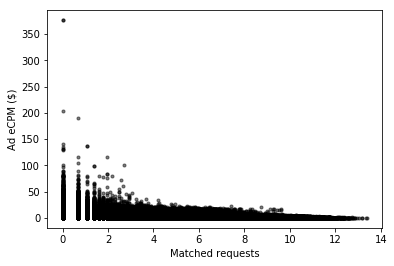

In [86]:
colors = (0,0,0)
area = np.pi*3
plt.scatter(np.log(ads_mtch['Matched requests']), ads_mtch['Ad eCPM ($)'], s=area, c=colors, alpha=0.5)
plt.title('')
plt.xlabel('Matched requests')
plt.ylabel('Ad eCPM ($)')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


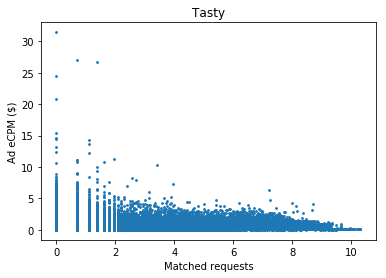

In [96]:
area = np.pi
plt.scatter(np.log(ads_tasty['Matched requests']), ads_tasty['Ad eCPM ($)'], s=area,  alpha=1)
plt.title('Tasty')
plt.xlabel('Matched requests')
plt.ylabel('Ad eCPM ($)')
plt.show()

Look at seasonality of Ad eCPM:

In [372]:
grouped = ads_mtch.groupby(['Days_'])

In [222]:
ave_eCPM = grouped.agg({'Ad eCPM ($)' : np.mean}).reset_index()

In [373]:
matched_request = grouped.agg({'Matched requests' : np.sum}).reset_index()

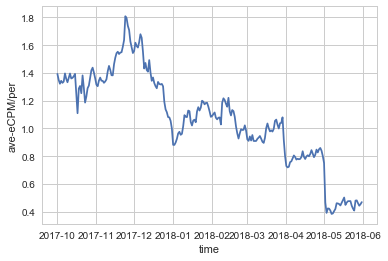

In [223]:
fig, ax = plt.subplots()
ax.plot_date(ave_eCPM['Days_'], grped_ads_ovall_ecpm['Ad eCPM ($)'], 'b-')
plt.xlabel('time')
plt.ylabel('ave-eCPM/per')
plt.show()

In [375]:
stdz_eCPM = preprocessing.scale(grped_ads_ovall_ecpm['Ad eCPM ($)'])
stdz_impression = preprocessing.scale(sum_impression)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the scale function.



In [ ]:
stdz_reqeust = preprocessing.scale(grped_ads_ovall_ecpm['Ad eCPM ($)'])

In [378]:
stdz_request_ratio = preprocessing.scale(matched_request['Matched requests'])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the scale function.



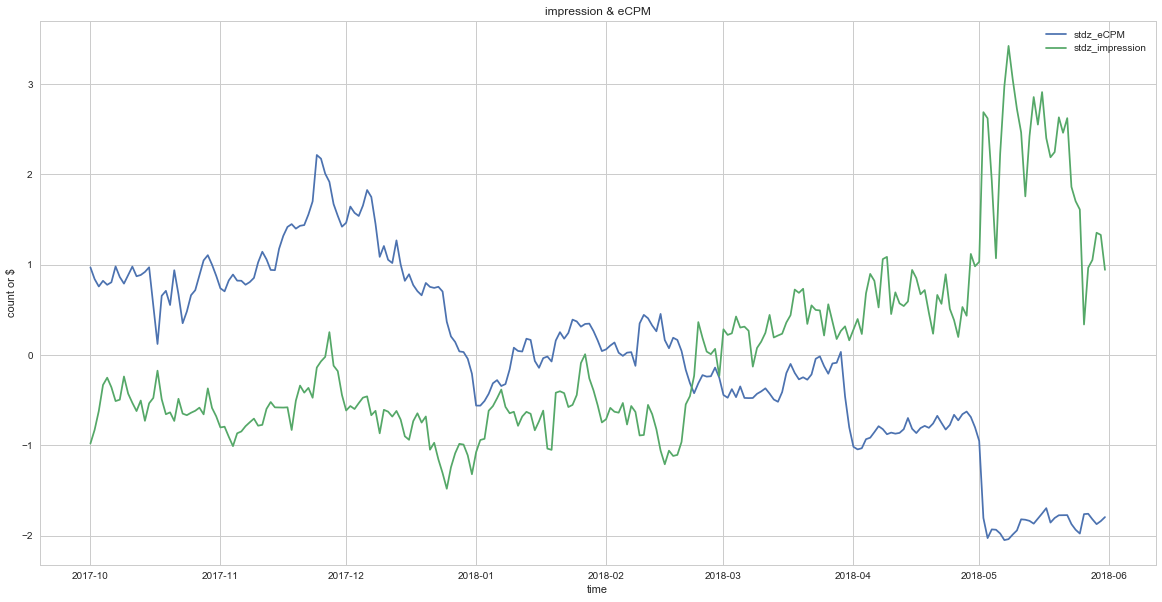

In [397]:
fig, ax = plt.subplots()
ax.plot_date(ave_eCPM['Days_'], stdz_eCPM, 'b-', label = 'stdz_eCPM')
ax.plot_date(ave_eCPM['Days_'], stdz_impression, 'g-', label = 'stdz_impression')
ax.legend()
plt.xlabel('time')
plt.ylabel('count or $')
plt.title('impression & eCPM')
plt.show()

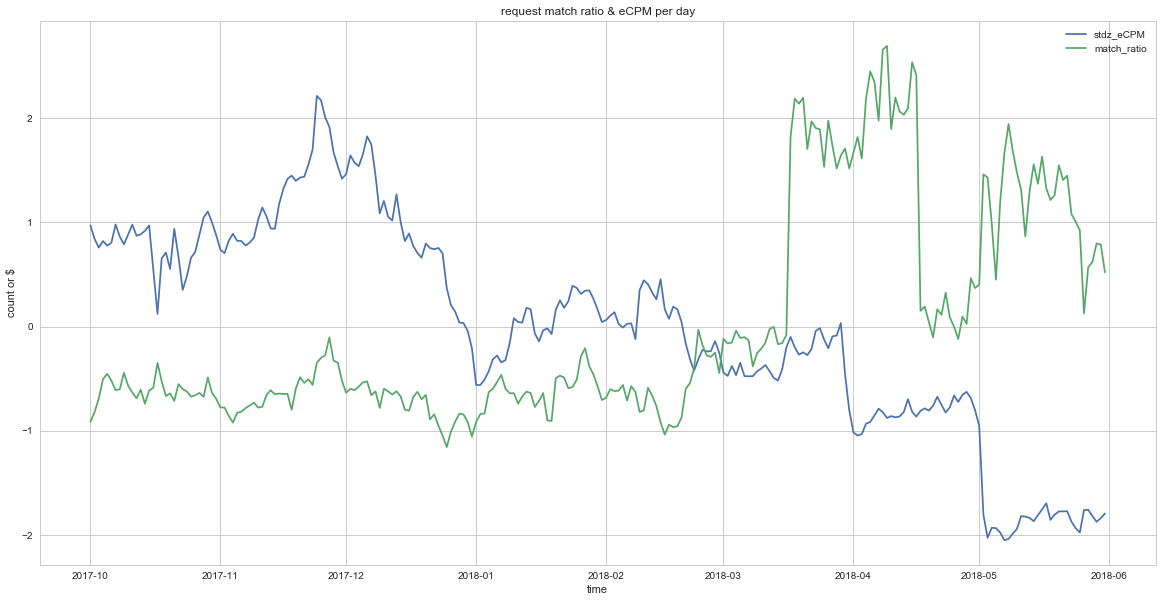

In [396]:
fig, ax = plt.subplots()
ax.plot_date(ave_eCPM['Days_'], stdz_eCPM, 'b-', label = 'stdz_eCPM')
ax.plot_date(ave_eCPM['Days_'], stdz_request_ratio, 'g-', label = 'match_ratio')
ax.legend()
plt.xlabel('time')
plt.ylabel('count or $')
plt.title('request match ratio & eCPM per day')
plt.show()

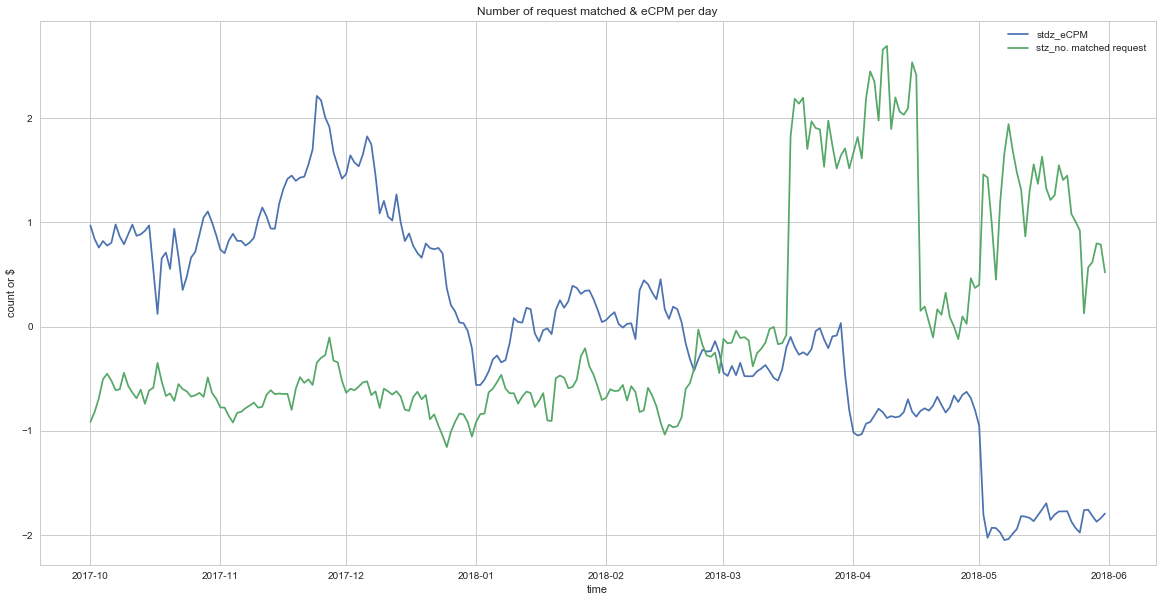

In [399]:
fig, ax = plt.subplots()
ax.plot_date(ave_eCPM['Days_'], stdz_eCPM, 'b-', label = 'stdz_eCPM')
ax.plot_date(ave_eCPM['Days_'], stdz_request_ratio, 'g-', label = 'stz_no. matched request')
ax.legend()
plt.xlabel('time')
plt.ylabel('count or $')
plt.title('Number of request matched & eCPM per day')
plt.show()

Analyze seasonality: eCPM vs. time

Disaggregate a time series into three components -- trend, seasonal and residual.

* The trend component is supposed to capture the slowly-moving overall level of the series.
* The seasonal component captures patterns that repeat every season.
* The residual is what is left. It may or may not be autocorrelated. 

In [369]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = time_ecpm['Ad eCPM ($)'].values.tolist()
result = seasonal_decompose(series, model='addictive', freq = 7)

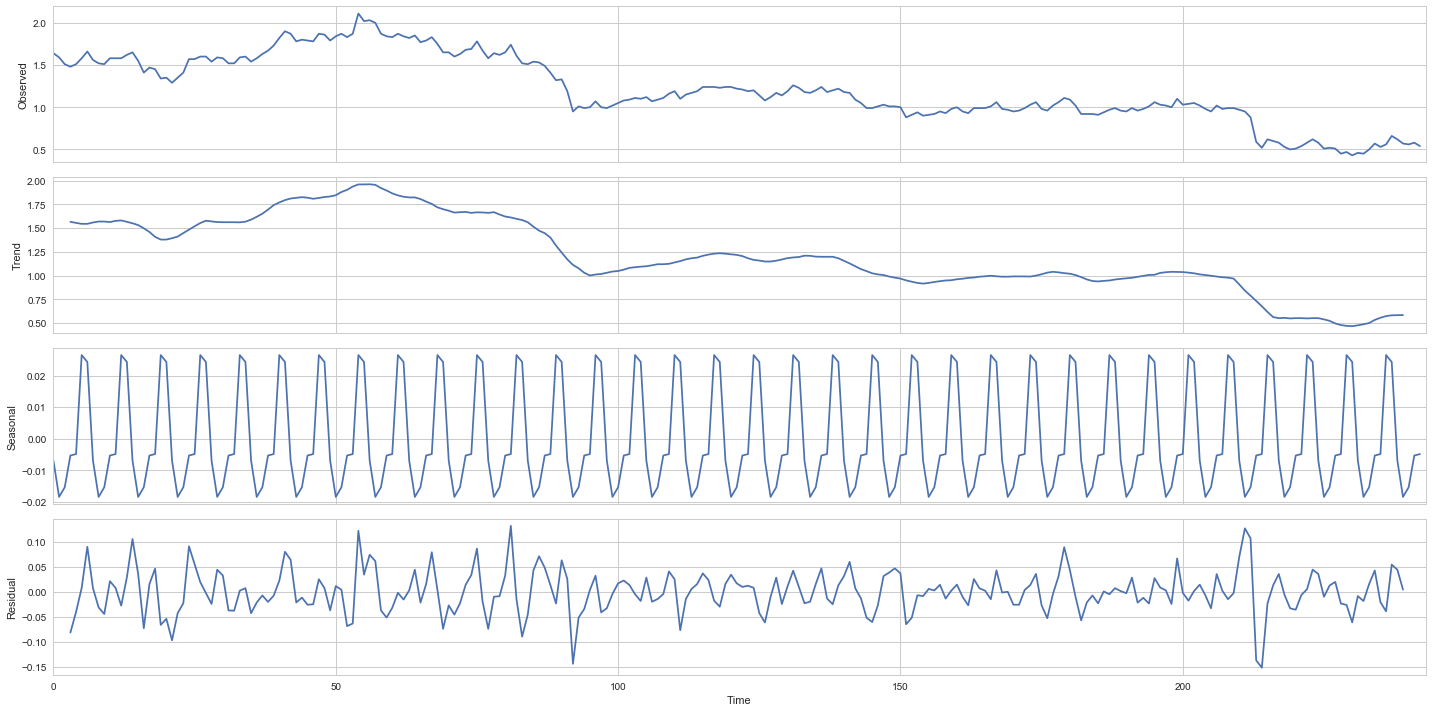

In [388]:
result.plot()
pyplot.show()

In [338]:
time_ecpm = pd.DataFrame()
time_ecpm['Ad eCPM ($)'] = ovall_ecpm['Ad eCPM ($)']
time_ecpm['Day'] = ave_eCPM['Days_']
time_ecpm.set_index('Day',inplace=True)
time_ecpm = (time_ecpm
       .resample('D')
       .mean()
       .interpolate('linear'))

In [347]:
time_ecpm.index

DatetimeIndex(['2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04',
               '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08',
               '2017-10-09', '2017-10-10',
               ...
               '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25',
               '2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29',
               '2018-05-30', '2018-05-31'],
              dtype='datetime64[ns]', name='Day', length=243, freq='D')

In [350]:
stl = decompose(time_ecpm, period=30)
stl

In [394]:
st2 = decompose(time_ecpm, period=7)
st2

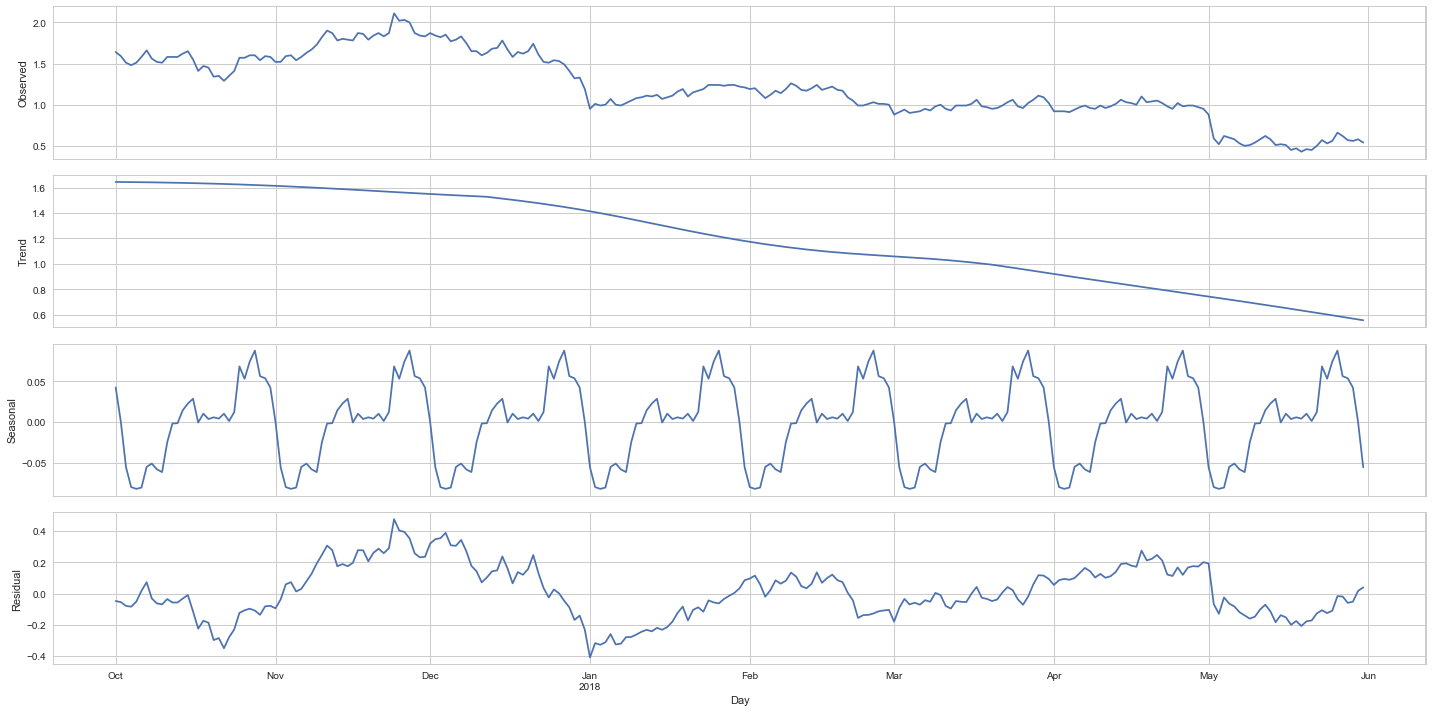

In [387]:
stl.plot(); # monthly

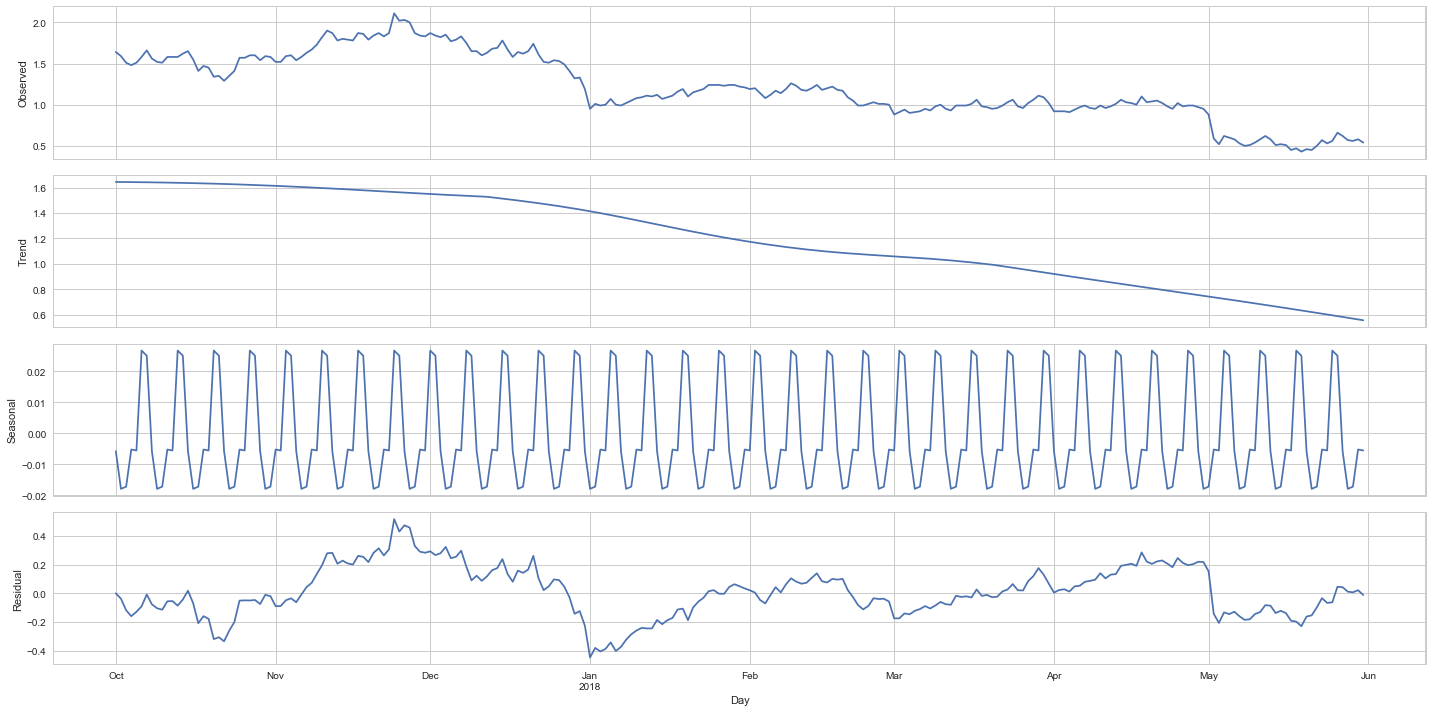

In [386]:
st2.plot(); # weekly